Relatório do trabalho
==============
**Nome:** Álvaro Leandro Cavalcante Carneiro
**Linguagem utilizada:** Python 3.6

Os códigos e o relatório foram desenvolvidos em um Jupyter notebook.

# Qual o problema ? 
Utilizar uma rede neural no modelo perceptron para identificar 3 classes de flores baseados em suas características de tamanho de pétalada e sépala.

## Importação das bibliotecas
Ferramentas usadas em todo o processo de desenvolvimento

In [1]:
import random
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import time
import itertools
from sklearn.metrics import confusion_matrix

# Análise Exploratória dos Dados (AED)
A ideia a princípio é entender um pouco mais do *dataset* e deixar os dados em um formato que seja favorável para o aprendizado da rede neural perceptron.

O primeiro passo foi ler o arquivo baixado aqui: http://archive.ics.uci.edu/ml/datasets/Iris.
O arquivo em questão não possuia colunas, portanto eu modifiquei o mesmo para adicionar o nome das colunas na primeira linha e deixá-lo no formato .CSV ao invés do .DATA.

O *dataset* está sendo lido com o método *read_csv* do pandas, que transforma o conjunto de dados em um *dataframe*, que por sua vez possui diversos métodos nativos para manipular os dados. Um desse métodos é o *head*, onde é possível visualizar as primeiras linhas do *dataframe*.

In [2]:
dataframe = pd.read_csv('/home/alvaro/Documentos/mestrado/computação bio/redes neurais/datasets/iris2.csv', header = 0)

dataframe.head()

,sepal-length,sepal-width,petal-length,petal-width,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


Um pré-requisito na mineração dos dados é verificar se o *dataframe* possui inconsistências quanto aos valores, podendo ser algum outlier, ruído, valor vazio, etc...

Para isso, é utilizado o método *isna* para contabilizar os registros vazios por coluna e também o método *describe* que gera um sumário por coluna dos valores ali contidos.

In [3]:
print('Valores nulos:')
print(dataframe.isna().sum())
dataframe.describe()

Valores nulos:
sepal-length    0
sepal-width     0
petal-length    0
petal-width     0
class           0
dtype: int64


,sepal-length,sepal-width,petal-length,petal-width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


## Mostrando a dispersão dos dados
É interessante também plotar um gráfico para mostrar o comportamento da dispersão das classes do conjunto, sendo possível inclusive ver se o problema é linearmente separável.

Antes disso, é necessário dividir o *dataframe* em uma variável chamada **previsores** e outra chamada **classe**. Como o nome sugere, os previsores são as colunas com as características das flores (atributos previsores) que serão utilizados para tentar ajustar os pesos da rede de maneira à generalizar uma solução que encontre as classes corretamente.

In [4]:
previsores = dataframe.iloc[:, 0:4] 
classe = dataframe['class']

<Figure size 432x288 with 0 Axes>

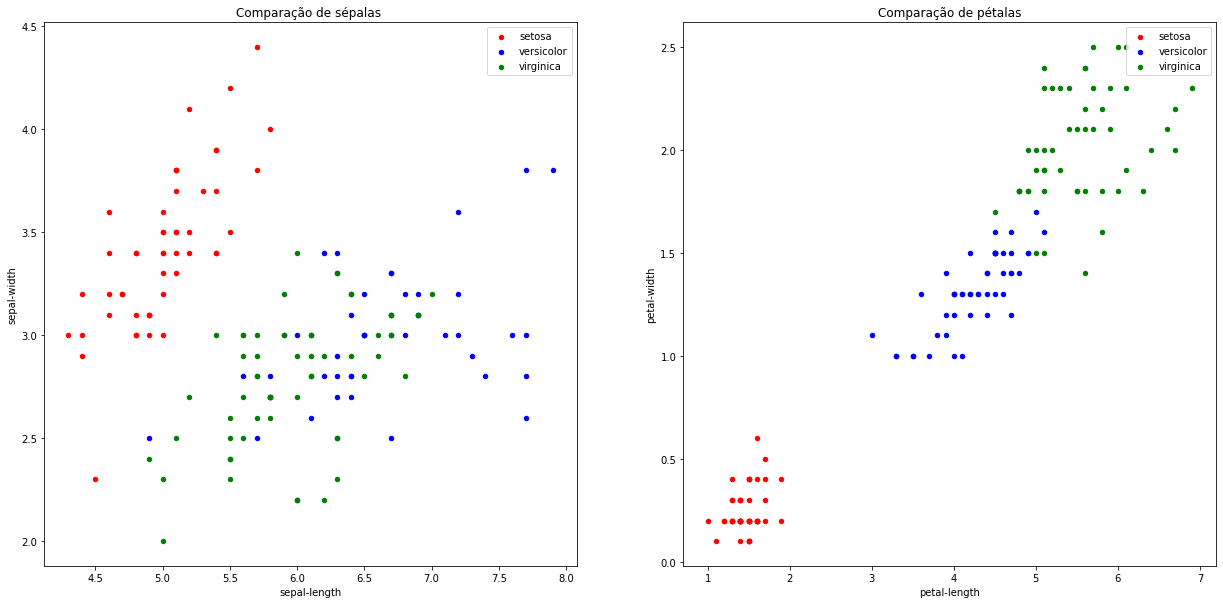

In [5]:
# iniciando a figura
plt.figure()
fig,ax=plt.subplots(1,2,figsize=(21, 10))

# separando o dataset por classe
setosa = dataframe[dataframe['class']=='Iris-setosa']
versicolor = dataframe[dataframe['class']=='Iris-versicolor']
virginica = dataframe[dataframe['class']=='Iris-virginica']

# plotando os conjuntos no gráfico de dispersão
setosa.plot(x="sepal-length", y="sepal-width", kind="scatter",ax=ax[0],label='setosa',color='r')
virginica.plot(x="sepal-length",y="sepal-width",kind="scatter",ax=ax[0],label='versicolor',color='b')
versicolor.plot(x="sepal-length", y="sepal-width", kind="scatter", ax=ax[0], label='virginica', color='g')

setosa.plot(x="petal-length", y="petal-width", kind="scatter",ax=ax[1],label='setosa',color='r')
versicolor.plot(x="petal-length",y="petal-width",kind="scatter",ax=ax[1],label='versicolor',color='b')
virginica.plot(x="petal-length", y="petal-width", kind="scatter", ax=ax[1], label='virginica', color='g')
# Adicionado legendas
ax[0].set(title='Comparação de sépalas ', ylabel='sepal-width')
ax[1].set(title='Comparação de pétalas',  ylabel='petal-width')
ax[0].legend()
ax[1].legend()
plt.show()

Podemos ver que as classes virgínica e versicolor são as mais complicadas de serem separadas, principalmente quando olhamos para o tamanho das pétalas.

## Normalização dos atributos previsores
O método *isnul()* mostrou que não há nenhum registro vazio no nosso *dataset* e é possível observar que os valores também parecem estar todos coerentes, sem a presença de outliers, como podemos notar pelo desvio padrão, mínimo e máximo de cada coluna e também no gráfico de dispersão.

Todavia, existe uma variação relativamente grande dentro do nosso domínio de atributos previsores. O atributo *petal-width* por exemplo, tem uma média de valor de 1.1, enquanto o *sepal-length* possui uma média de 5.8. Dito isso, se faz necessário a padronização desses valores, para que nosso ajuste dos pesos não seja muito influenciado por essa diferença no tamanho da entrada. 

O tipo de normalização escolhido foi o **Z-score**, de forma arbitrária, por ser bastante comum em problemas como esse. Sua fórmula é bastante simples e foi representada no método *normalizacao_z_score*.

In [6]:
def normalizacao_z_score(valor):
    media = previsores[valor.name].mean()
    desvio_padrao = previsores[valor.name].std()

    return (valor - media) / desvio_padrao

O método *apply()* do pandas juntamente com a **lambda** aplicam o processo matemático do método de normalização em cada um dos registros do *dataframe*. Os novos registros normalizados podem ser vistos abaixo.

In [7]:
previsores = previsores.apply(lambda row: normalizacao_z_score(row))
previsores.head()

,sepal-length,sepal-width,petal-length,petal-width
0,-0.897674,1.028611,-1.336794,-1.308593
1,-1.139200,-0.124540,-1.336794,-1.308593
2,-1.380727,0.336720,-1.393470,-1.308593
3,-1.501490,0.106090,-1.280118,-1.308593
4,-1.018437,1.259242,-1.336794,-1.308593


## Tratando valores categóricos
O próximo passo será transformar o valor da classe de categórico para discreto, para que seja possível aplicar os cálculos, como o erro da saída por exemplo.

Para isso foi criado o método *get_dicionario_classes* que gera uma estrutura de dicionário dinâmica, baseado na quantidade de classes do problema que está sendo tratado. O processo é muito simples, basta percorrer a classe existente e atribuir um valor inteiro para cada classe.

In [8]:
def get_dicionario_classes(classe):
    dict_classes = {}
    count = 0
    
    for i in classe.unique():
        dict_classes[i] = count
        count += 1
        
    return dict_classes

In [9]:
dict_classes = get_dicionario_classes(classe)
print(dict_classes)

{'Iris-setosa': 0, 'Iris-versicolor': 1, 'Iris-virginica': 2}


Podemos ver acima os valores que nosso método atribuiu para cada uma das classes.

Basta agora repetir o processos anterior de usar o método *apply()*, porém agora passando no *lambda* o método que vai atribuir a classe a seu determinado valor no dicionário que criamos anteriormente.

In [10]:
def transformar_categorico_em_numerico(valor, dict_classes):
    return dict_classes[valor]
    
classe = classe.apply(lambda row: transformar_categorico_em_numerico(row, dict_classes))
print(classe.value_counts())

2    50
1    50
0    50
Name: class, dtype: int64


## Lidando com problemas multi-classe
O problema em questão é multi-classe, ou seja, possuímos mais de duas classes como resposta na camada de saída, podendo ser, íris-setosa, versicolor ou virginica.
Para problemas binários utilizar um único neurônio com a saída de 0 e 1 nos basta, todavia aqui, vamos precisar criar um novo neurônio para cada classe, totalizando 3 na nossa camada de saída.

Além de modificar a estrutura da rede neural, também vamos precisar codificar nossos valores, uma vez que, ao invés de um valor escalar vamos trabalhar com um array na saída da rede, sendo ele representado por: [1,0,0], [0,1,0] e [0,0,1].

In [11]:
def codificar_classe():
    classe_codificada = {}
    array_classe = [1] + [0] * (len(classe.unique()) - 1) #cria um array dinâmico baseado na 
    #quantidade de classes, é [1,0,0] para esse problema mas poderia ser [1,0,0,0....,0].
    count = 1    
    classe_codificada[0] = array_classe.copy()
    
    for i in range(len(classe.unique()) - 1): # percorre todas as classes -1, pois já temos a primeira posição do dicionário por padrão
        array_classe[count - 1] = 0 # o valor 1 atual vira 0
        array_classe[count] = 1  # a próxima casa do array vira 1   
        classe_codificada[count] = array_classe.copy()
        count += 1
    
    return classe_codificada      

classe_codificada = codificar_classe()

In [12]:
classe_codificada

{0: [1, 0, 0], 1: [0, 1, 0], 2: [0, 0, 1]}

A ideia do método *codificar_classe* é criar mais um dicionário, como é possível ver acima, onde cada posição representa uma classe codificada em um array de binários. O tamanho desse array é dinâmico dependendo do número de classes e a ideia é ir movimentando o valor do 1 conforme as iterações.

Feito isso, basta repetir o processo para substituir o valor da classe.

In [13]:
def substituir_classe_codificada(valor, classe_codificada):
    return classe_codificada[valor]

classe = classe.apply(lambda row: substituir_classe_codificada(row, classe_codificada))
print(classe.head())

0    [1, 0, 0]
1    [1, 0, 0]
2    [1, 0, 0]
3    [1, 0, 0]
4    [1, 0, 0]
Name: class, dtype: object


Com isso, a classe agora está em uma estrutura que vai suportar o problema multi-classe.

## Divisão do dataframe
Agora que os dados do *dataframe* já estão no formato necessário, basta dividir as bases em treinamento, validação e teste, usando a proporção de 70%, 15% e 15%.

Para isso foi criado o método *dividir_dataframe* onde iremos utilizar o método *sample* do pandas para pegar amostras aleatórias sem reposição do nosso dataframe, e a partir dessa amostra iremos criar os outros conjuntos.

O *x_treinamento* vai ser a fatia responsável por treinar a rede e ajustar os pesos. O teste do treinamento será feito ao final de cada época na base chamada *x_teste*, nos dando uma avaliação não enviesada dos resultados da rede em dados não vistos no treino.

Após a rede estar completamente treinada, iremos usar a base de *x_validacao* para gerar novas previsões baseado em atributos previsores nunca antes vistos pela rede, nos dando uma validação final da eficácia do treinamento.

Os parâmetros com sulfixo *p* indicam o porcentagem que será atribuida para cada base de dados e o último parâmetro de época vai mudar o retorno da função dependendo se o perceptron é do tipo que atualiza os pesos por registro ou por época.

In [14]:
def dividir_dataframe(previsores, classe, p_treinamento, p_teste, p_validacao, epoca = False):
    x_treinamento = previsores.sample(frac = p_treinamento)
    y_treinamento = classe[x_treinamento.index]
    
    x_teste_sem_previsores = previsores.drop(x_treinamento.index)
    nova_p_teste = p_teste / (1 - p_treinamento)
    
    x_teste = x_teste_sem_previsores.sample(frac = nova_p_teste)
    y_teste = classe[x_teste.index]
    
    x_validacao = x_teste_sem_previsores.drop(x_teste.index)
    y_validacao = classe[x_validacao.index]
    
    if epoca == False:
        return x_treinamento.reset_index(drop=True), y_treinamento.reset_index(drop=True), \
        x_teste.reset_index(drop=True), y_teste.reset_index(drop=True), x_validacao.reset_index(drop=True), y_validacao.reset_index(drop=True)
    else:
        # não tem reset index na classe
        return x_treinamento.reset_index(drop=True), y_treinamento, \
        x_teste.reset_index(drop=True), y_teste, x_validacao.reset_index(drop=True), y_validacao

A nomenclatura de "x" representa os atributos previsores e "y" a classe.

Depois de criar a fração de treinamento, eu removo dos meus previsores todos os dados que estão na porção de treinamento, pois uma regra importante a ser seguida na divisão dos dados é o particionamento, ou seja, nenhum dos registros de treinamento deve estar no conjunto de teste e vice versa. 

Depois disso, meu conjunto total se torna o resto que não está no conjunto de treinamento, portanto as porcentagens também são redimensionadas, por exemplo, se antes tinhamos 15% do nosso conjunto para treinamento e 15% para validação, agora cada um desses 15% representa 50%, pois o novo 100% está sem os registros de treinamento.

Feito isso, basta dividir novamente a base em teste e validação e retornar os valores.

## Inicialização dos pesos
Os pesos serão inicializados de forma aleatória para então serem gradativamente ajustados conforme a rede neural converge.
Para isso, foi criado o método *inicializar_pesos*, que percorre cada um dos neurônios e gera um vetor da quantidade de pesos que ele possui baseado nas suas conexões sinapticas com os neurônios da próxima camada.

Além disso, o método também recebe um parâmetro chamado dominio, que é o intervalo de valores que os pesos serão gerados, os testes a princípio foram realizados em um domínio de [0,1].

In [15]:
def inicializar_pesos(dominio):
    pesos_final = []
    
    for i in range(len(previsores.columns)):
        pesos = [] 
        for j in range(len(dict_classes)):
            pesos.append(random.uniform(dominio[0], dominio[1]))
        pesos_final.append(pesos)
    return pesos_final

In [16]:
pesos = inicializar_pesos([0, 1])
print('Pesos:', pesos)

Pesos: [[0.7360587056949205, 0.8612937010723815, 0.6228282077201314], [0.26468934257186594, 0.018796544521857195, 0.9980635594244514], [0.1818473334234445, 0.03376336128851887, 0.4111958412558425], [0.7683832399473948, 0.518827169093489, 0.29641452704288596]]


Como podemos ver acima, o array de pesos para esse problema possui 4 posições com 3 pesos em cada uma das posições. Isso acontece porque possuímos 4 neurônios (nosso atributos de entrada/previsores sem considerar o bias nesse caso) conectados à 3 neurônios (um neurônio para cada saída possível), portanto cada um dos 4 neurônios possui 3 pesos (conexões) cada um. 

Para obter o número de conexões por camada basta multiplicar o número de neurônios da camada atual pelos número de neurônios na próxima camada, dessa forma temos: 4 * 3 = 12.

## Implementação da função de soma
A função de soma acontece em todos os neurônios, somando o valor do produto da multiplicação entre os neurônios adjacentes anteriores com os pesos das sinapses artificiais.
Esse valor de soma é o valor final do neurônio após receber todas as sinapses e será usado na função de ativação para indicar se o neurônio em questão foi excitado ou inibido.


A soma do produto pode ser feita de forma simples usando o método *dot* do numpy, retornando um produto escalar.

In [17]:
def somatoria(entradas, pesos):
    return np.dot(entradas, pesos) 

## Função de ativação
A função de ativação por *default* no perceptron é a chamada "*step function* (função degrau)", onde o neurônio artificial é excitado ou não baseado em um *threshold* (limiar) pré definido.
Nesse caso, se o valor do neurônio for maior que 0 ele retorna o 1, excitando a célula, caso contrário, retorna 0.

Por ser um problema multiclasse, foi criado um laço *for* para percorrer o array da classe e excitar todas as posições em que o valor é maior que 0. 

Claro que isso acaba gerando um problema onde mais de um neurônio por vez na camada de saída pode ser excitado. 

In [18]:
def funcao_ativacao_step(soma):
    ativacao = []
    for i in soma:
        if i > 0:
            ativacao.append(1)
        else:
            ativacao.append(0)

    return ativacao, ativacao

## Função de custo
A função de custo é a responsável por calcular o erro da rede neural ao comparar o valor correto com o valor que foi previsto.

A variável de *erro* indica se a rede neural errou a previsão ou acertou (uma vez que os pesos aqui não serão atualizados em caso de acerto), já a variável *valor_erro*, nos indica o valor exato em cada neurônio de saída que a rede classificou incorretamente, para ter uma precisão maior na atualização dos pesos.

Por exemplo, se o valor previsto foi: [0.8,0.37,0.16] e o valor real é: [0,1,0], a variável *valor_erro* vai trazer o erro do algoritmo por posição: [0.8, 0.63, 0.16], totalizando uma soma de 1.59. 

In [19]:
def funcao_custo(valor_correto, valor_previsto, valor_ativacao):
    erro = valor_correto != valor_previsto
    valor_erro = list(abs(np.array(valor_correto) - np.array(valor_ativacao)))
    return erro, sum(valor_erro) # valor escalar

## Função de atualização de peso
A formula da atualização de pesos no perceptron foi representada no método de *atualizar_peso*

Com ela, conseguimos ajustar os pesos seguindo uma taxa de aprendizado (basicamente o tamanho do "passo") além de levar em consideração a grandeza da entrada e o quanto a previsão estava incorreta.

Algo importante de se considerar é que o perceptron faz a atualização dos pesos POR REGISTRO, ou seja, a cada registro apresentado a rede neural que é classificado de forma incorreta é gerado uma atualização nos pesos, podendo dificultar a convergência devido à sensibilidade aos dados contidos no *dataframe* e também aumentando o tempo de execução do algoritmo.

In [20]:
def atualizar_peso(entrada, peso, erro, tx_aprendizado):
    novo_peso = peso + (tx_aprendizado * entrada * erro)
    return novo_peso

## Bias
O Bias é a constante que iremos adicionar como sendo uma das colunas do *dataframe*. Essa coluna, assim como as demais, irá se transformar em um neurônio da rede, que vai ajudar nos cálculos dos pesos.

O Bias tem uma atualização diferenciada, pois não leva em consideração a entrada, portanto foi criado um método para atualizar o bias.

In [21]:
def atualizar_bias(entrada, peso, erro, tx_aprendizado):
    novo_peso = peso + np.float64(tx_aprendizado * erro)
    return novo_peso

In [22]:
previsores['bias'] = 1 # adicionando o bias na coluna

## Matriz de confusão
Foi utilizado a biblioteca do *sklearn* para a implementação da matriz de confusão, sendo necessário apenas adaptar o formato dos dados para um array de valores escalares. Esse processo de adaptação foi feito no método *get_matriz_confusao*. 

Também foi necessário adicionar um *try/except* para retornar um array vazio em caso de erros na criação da matriz de confusão, isso se deu pelo fato de que ao utilizar a função de ativação "degrau" mais de um neorônio poderia ser ativado ao mesmo tempo, gerando problemas de incompatibilidade na geração da matriz.

In [40]:
def get_matriz_confusao(valor_correto, valor_previsto):
    try:
        previsao = np.array(valor_previsto.copy()) # deep copy da variável
        previsao = np.where(previsao == 1)[1] # transformando em um array de valores escalares

        correto = np.array(list(valor_correto.values))
        correto = np.where(correto == 1)[1]

        matriz_confusao = confusion_matrix(correto, previsao)

        return matriz_confusao
    except:
        return []

## Implementação do perceptron
O método *treinar* é que a que vai implementar de fato todas as etapas que foram mostradas até agora, recebendo o número de épocas que iremos executar o perceptron, onde cada época representa a passagem de todo o *dataframe* na pela rede, a função de ativação que será utilizada, a função de custo e os conjuntos de treinamento e teste, além da taxa de aprendizado. 

In [24]:
def treinar(epocas, f_ativacao, f_custo, pesos, x_treinamento, y_treinamento, x_teste, y_teste,
           tx_aprendizado):

    execucoes = 0
    precisoes_treinamento = [] # convergência da base de treinamento ao longo das épocas
    precisoes_teste = [] # convergência da base de teste ao longo das épocas
    melhores_pesos = [] # registra o melhor conjunto de pesos para a validação posterior
    melhor_matriz_treinamento = [] # matriz confusão de treinamento 
    melhor_matriz_teste = [] #  matriz confusão de teste

    while execucoes < epocas: # parada ao executar todas as épocas.
        precisao = 0
        iteracao = 0
        valores_previstos = []
        # x_treinamento = x_treinamento.sample(frac=1).reset_index(drop=True) # embaralhar os valores dos previsores, por que sem isso, podemos ter sempre uma ordem fixa de ajuste de pesos, prejudicando a rede

        for i in x_treinamento.values: # percorre cada registro individualmente
            entradas = i   
            soma = somatoria(entradas, pesos)
        
            # a ativacao retorna qual dos 3 neurônios de saíde foram excitados e também o 
            # valor real da ativação, para calculo do erro.
            neuronio_excitado, valor_ativacao = f_ativacao(soma) 
            valores_previstos.append(neuronio_excitado)

            erro, valor_erro = f_custo(y_treinamento[iteracao], neuronio_excitado, 
                                       valor_ativacao)
            # atualiza os pesos em caso de erro
            if erro == True:
                count = 0
                # percorre cada coluna para atualizar o peso e o bias
                for i in entradas:
                    if count == len(entradas) - 1:
                        novo_peso = atualizar_bias(i, pesos[count], valor_erro, tx_aprendizado)
                    else:
                        novo_peso = atualizar_peso(i, pesos[count], valor_erro, tx_aprendizado)
                    
                    pesos[count] = novo_peso
                    count += 1
            else:
                precisao += 100 / len(x_treinamento) # aumenta precisão gradativamente

            iteracao += 1
        
        precisoes_treinamento.append(precisao) # registra precisão ao fim da época
        melhor_matriz_treinamento = get_matriz_confusao(y_treinamento, valores_previstos) if precisoes_treinamento[execucoes] >= max(precisoes_treinamento) else melhor_matriz_treinamento
        melhores_pesos = pesos.copy() if precisoes_treinamento[execucoes] >= max(precisoes_treinamento) else melhores_pesos

        teste_rede = testar(pesos, x_teste, y_teste, f_ativacao, f_custo)
        precisoes_teste.append(teste_rede[0])
        melhor_matriz_teste = teste_rede[1] if precisoes_teste[execucoes] >= max(precisoes_teste) else melhor_matriz_teste
        execucoes += 1
        
    return precisoes_treinamento, precisoes_teste, melhores_pesos, melhor_matriz_treinamento, melhor_matriz_teste

## Método de teste
Ao final de cada época a rede teve seu desempenho avaliado na base de teste, isso foi feito no método *testar* onde usamos os pesos ajustados no treinamento apenas para pegar os acertos e erros no conjunto de teste.

In [25]:
def testar(pesos, x_previsores, y_classe, f_ativacao, f_custo):
    precisao = 0
    iteracao = 0
    valores_previstos = [] # armazena os valores previstos para cada registro
    
    for i in x_previsores.values:
        entradas = i   
        soma = somatoria(entradas, pesos)
        
        neuronio_excitado, valor_ativacao = f_ativacao(soma)
        valores_previstos.append(neuronio_excitado)

        erro, valor_erro = f_custo(y_classe[iteracao], neuronio_excitado, valor_ativacao)
        
        # faz a contagem da precisão, incrementando por acerto baseado no total de registros
        if erro == 0: 
            precisao += 100 / len(x_previsores)
        
        iteracao += 1
        
    matriz_confusao = get_matriz_confusao(y_classe, valores_previstos)

    return precisao, matriz_confusao

### Exibindo os resultados
Os resultados de precisão, média, desvio padrão e os gráficos de convergência são exibidos nos método abaixo de *exibir_resultados* e *plotar_convergencia*.

In [26]:
def exibir_resultados(precisao_treinamento, precisao_teste, resultado_final):
    print('Melhor precisão de treinamento', max(precisao_treinamento))
    print('Melhor precisão de teste', max(precisao_teste))
    print('Melhor precisão de validação', max(resultado_final))
    print('Média precisão de treinamento', np.mean(precisao_treinamento))
    print('Média precisão de teste', np.mean(precisao_teste))
    print('Média precisão de validação', np.mean(resultado_final))
    print('Desvio Padrão precisão de treinamento', np.std(precisao_treinamento))
    print('Desvio Padrão precisão de teste', np.std(precisao_teste))
    print('Desvio Padrão precisão de validação', np.std(resultado_final))

In [27]:
def plotar_convergencia(precisao_treinamento, precisao_teste):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 8)) # iniciar a figura
    # plotar a figura de treinamento
    axes[0].plot(precisao_treinamento, color = 'blue')
    axes[0].legend(['Treinamento'])
    # plotar a figura de teste
    axes[1].plot(precisao_teste, color = 'orange')
    axes[1].legend(['Teste'])

    plt.xlabel('Épocas')
    plt.ylabel('Precisão')
    plt.show()

## Testes no perceptron
Uma vez que a rede perceptron foi criada basta testar seus resultados com diferentes parâmetros. Para isso, foi criado a função genérica chamada *executar_perceptron*, que recebe os parâmetros desejados e treina a rede. 

Cada vez que o método *executar_perceptron* é chamado, o algoritmo é inicializado 30 vezes, sem nenhuma mudança nos parâmetros, apenas gerando um conjunto inicial de pesos diferente para cada inicialização e também uma partição nova dos dados, pois ambos são aleatórios.

Isso é feito porque as redes neurais são algoritmos extremamente estocásticos, o que faz com que sejam inclusive evitados em algumas áreas, portanto é interessante tentar treinar a rede várias vezes para capturar seus melhores resultados. 

O método *executar_perceptron* também registra o desempenho e convergência da rede durante as iterações, além de retornar os valores máximos ao final, para que possamos usar posteriormente na otimização de parâmetros.

In [48]:
def executar_perceptron(funcao_ativacao, funcao_custo, epocas, dominio_pesos = [0, 1], 
                       tx_aprendizado = 0.001):
    # os arrays servem para registrar os valores de cada inicialização da rede
    convergencia_treinamento = [0]
    convergencia_teste = [0]
    precisao_treinamento = []
    precisao_teste = []
    resultado_final = []
    matriz_confusao_treinamento = []
    matriz_confusao_teste = []
    matriz_confusao_validacao = []
    start_time = time.time() # tempo de execução
    
    for i in range(30): # 30 execuções
        x_treinamento, y_treinamento, x_teste, y_teste, \
        x_validacao, y_validacao = dividir_dataframe(previsores, classe, 0.7, 0.15, 0.15)
        
        pesos = inicializar_pesos(dominio_pesos) 
        
        treinamento = treinar(epocas, funcao_ativacao, funcao_custo, pesos, x_treinamento,
                                     y_treinamento, x_teste, y_teste, tx_aprendizado)
        
        # É salvo apenas o melhor resultado da convergência, para plotar um único gráfico
        convergencia_treinamento = treinamento[0] if max(treinamento[0]) >= \
                                max(convergencia_treinamento) else convergencia_treinamento
        
        convergencia_teste = treinamento[1] if max(treinamento[1]) >= max(convergencia_teste) \
                                        else convergencia_teste
        
        precisao_treinamento.append(max(treinamento[0]))
        precisao_teste.append(max(treinamento[1]))
        # avaliação do algoritmo ao final do treinamento na base de validação
        teste_final = testar(treinamento[2], x_validacao, y_validacao, 
                                      funcao_ativacao, funcao_custo)
        resultado_final.append(teste_final[0])
        
        matriz_confusao_treinamento = treinamento[3] if max(treinamento[0]) >= max(precisao_treinamento) else matriz_confusao_treinamento
        matriz_confusao_teste = treinamento[4] if max(treinamento[1]) >= max(precisao_teste) else matriz_confusao_teste
        matriz_confusao_validacao = teste_final[1] if teste_final[0] >= max(resultado_final) else matriz_confusao_validacao

    plotar_convergencia(convergencia_treinamento, convergencia_teste)   
    exibir_resultados(precisao_treinamento, precisao_teste, resultado_final)
    print('Matriz de confusão de treinamento:\n', matriz_confusao_treinamento)
    print('Matriz de confusão de teste:\n', matriz_confusao_teste)
    print('Matriz de confusão de validação:\n', matriz_confusao_validacao)
    print("Tempo de execução: %s Segundos" % (time.time() - start_time))


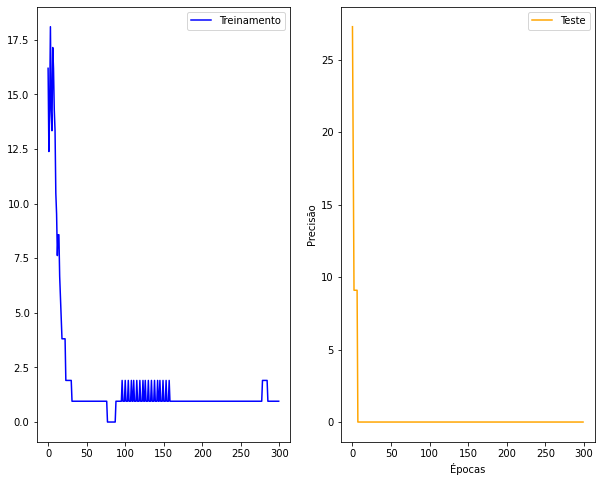

Melhor precisão de treinamento 18.095238095238095
Melhor precisão de teste 27.272727272727277
Melhor precisão de validação 17.391304347826086
Média precisão de treinamento 5.206349206349206
Média precisão de teste 6.969696969696968
Média precisão de validação 3.623188405797101
Desvio Padrão precisão de treinamento 4.879397093800851
Desvio Padrão precisão de teste 7.490428542005015
Desvio Padrão precisão de validação 4.773817128116117
Matriz de confusão de treinamento:
 []
Matriz de confusão de teste:
 []
Matriz de confusão de validação:
 []
Tempo de execução: 54.61538052558899 Segundos


In [49]:
executar_perceptron(funcao_ativacao_step, funcao_custo, 300)

### Resultados iniciais e ZeroR
Os testes inicias mostram uma precisão extremamente baixa, algo está definitivamente se comportando mal no algoritmo. Podemos ter certeza que o culpado é a implementação do algoritmo e não a base de dados devido a análise exploratória que foi feita anteriormente, revelando as características linearmente separáveis que deveriam proporcionar uma precisão maior que a encontrada até agora.

O "Zero R" pode ser utilizado para saber a precisão mínima que o algoritmo deve ter para ser considerado melhor do que não usar algoritmo algum. A precisão do zeroR, considerado o limiar mínimo, é dado pela proporção de registros da classe majoritária no *dataframe*.


Nesse *dataframe* as classes estão **normalmente distribuídas** em 3 partes iguais, fazendo com que a precisão majoritária sem algoritmos seja de **33%**, portanto, qualquer precisão inferior a isso torna o uso do algoritmo injustificável.


Todavia, ainda que nosso algoritmo seja considerado útil com 34% de acerto, ainda está longe de algo desejável.

# Melhorando os resultados
Os passos a seguir foram usados como meio de melhorar a precisão da rede perceptron.

### Função de ativação sigmoid
Como foi dito anteriormente, utilizar a função degrau para ativação pode ocasionar o aumento dos erros, devido a possibilidade de excitar vários neurônios ao passar pelo limiar especificado. Portanto foi criado uma nova função de ativação baseado na fórmula da sigmoid.

Com isso, os valores ficam em um intervalo de 0 e 1 e o neurônio escolhido para ser excitado é aquele com o maior valor, dessa forma, apenas um neurônio é excitado por vez

In [50]:
def funcao_ativacao_sigmoid(soma):
    valor_ativacao = list(1 / (1 + math.e ** -soma))
    index_excitacao = valor_ativacao.index(max(valor_ativacao))# pegar neurônio com maior valor  
    neuronio_excitado = [0] * len(soma) # zerar os valores dos neurônios de saída
    neuronio_excitado[index_excitacao] = 1 # definir o valor 1 para o neurônio com maior valor
    
    return neuronio_excitado, valor_ativacao

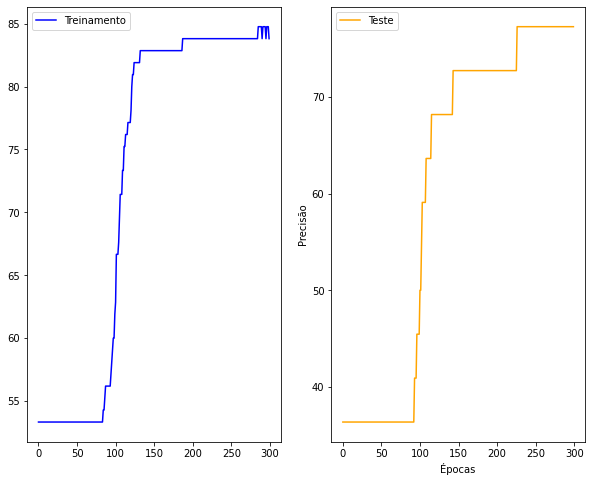

Melhor precisão de treinamento 84.76190476190457
Melhor precisão de teste 77.27272727272728
Melhor precisão de validação 78.26086956521739
Média precisão de treinamento 46.66666666666661
Média precisão de teste 45.9090909090909
Média precisão de validação 46.23188405797102
Desvio Padrão precisão de treinamento 19.123657749350244
Desvio Padrão precisão de teste 20.94035870250392
Desvio Padrão precisão de validação 20.284160691614606
Matriz de confusão de treinamento:
 [[33  2  0]
 [ 0 36  4]
 [ 0 10 20]]
Matriz de confusão de teste:
 [[9 0 0]
 [0 3 0]
 [0 5 5]]
Matriz de confusão de validação:
 [[5 1 0]
 [0 6 1]
 [0 3 7]]
Tempo de execução: 74.09392404556274 Segundos


In [51]:
executar_perceptron(funcao_ativacao_sigmoid, funcao_custo, 300)

A aplicação da função sigmoid gerou melhorias consideráveis nos resultados. Dessa vez, foi possível gerar as matrizes de confusão das classes 0, 1 e 2 respectivamente, onde a linha é o valor real e a coluna o valor que foi previsto.


Como é possível observar, a maior parte das classificações incorretas está entre a classe de iris versicolor e virginica, representado pelos valores 1 e 2 segundo o dicionário de classe criado anteriormente. Esse comportamente já era esperado, uma vez que suas características se misturam mais no espaço, dificultando o trabalho da rede neural. 


Na matriz de teste por exemplo, é possível notar que 50% das íris virginicas foram classificadas como sendo versicolor, portanto ainda é preciso otimizar mais os parâmetros do algoritmo a fim de melhorar sua capacidade de divisão no espaço de características.

Um outro parâmetro que pode ser otimizado é o domínio dos pesos, aumentando a precisão da busca pelos melhores pesos, que é refletido por sua vez em um maior número de oscilações nos gráficos de precisão.

Um domínio mais próximo a zero faz com que os valores comecem pequenos e aumentem gradativamente (baseado também no tamanho da taxa de aprendizado), fazendo uma busca mais aprofundada pelo ótimo global. 

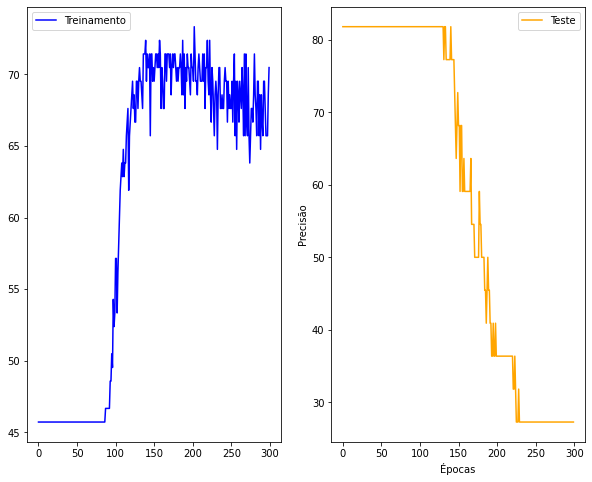

Melhor precisão de treinamento 73.33333333333319
Melhor precisão de teste 81.81818181818183
Melhor precisão de validação 78.26086956521739
Média precisão de treinamento 50.317460317460245
Média precisão de teste 51.06060606060607
Média precisão de validação 46.23188405797102
Desvio Padrão precisão de treinamento 15.795525134053552
Desvio Padrão precisão de teste 17.979301434523588
Desvio Padrão precisão de validação 20.408040884544054
Matriz de confusão de treinamento:
 [[30  3  0]
 [ 2 38  0]
 [ 1 22  9]]
Matriz de confusão de teste:
 [[6 0 0]
 [2 3 2]
 [0 0 9]]
Matriz de confusão de validação:
 [[12  0  1]
 [ 0  5  2]
 [ 0  2  1]]
Tempo de execução: 69.85689520835876 Segundos


In [53]:
executar_perceptron(funcao_ativacao_sigmoid, funcao_custo, 300, [-0.005, 0.005])

## Mean Squared Error e Root Mean Squared error
A função de custo que está sendo utilizada atualmente é a mais simples possível, onde comparamos a diferença entre a previsão atual com o valor esperado. Existem outras fórmulas um pouco mais completas que possuem um nível de precisão maior em estimar os custos.

A primeira delas é a função Mean Squared Error, representada no método *funcao_custo_mse*, que além de calcular o valor correto subtraído do valor previsto também eleva o resultado da subtração ao quadrado e os soma, gerando um valor escalar que pune mais erros maiores, deixando eles mais expressivos.


A Root Mean Squared Error, representada pelo método *funcao_custo_rmse* segue a mesma formula, porém submetendo os resultados finais a uma raiz quadrada.

In [54]:
def funcao_custo_mse(valor_correto, valor_previsto, valor_ativacao):
    erro = valor_correto != valor_previsto

    valor_erro = list(abs(np.array(valor_correto) - np.array(valor_ativacao)))
    erro_quadratico = list(map(lambda x: math.pow(x, 2), valor_erro))
    soma_erro_quadratico = sum(erro_quadratico)

    return erro, soma_erro_quadratico

In [55]:
def funcao_custo_rmse(valor_correto, valor_previsto, valor_ativacao):
    erro, valor_erro = funcao_custo_mse(valor_correto, valor_previsto, valor_ativacao)

    return erro, math.sqrt(valor_erro)

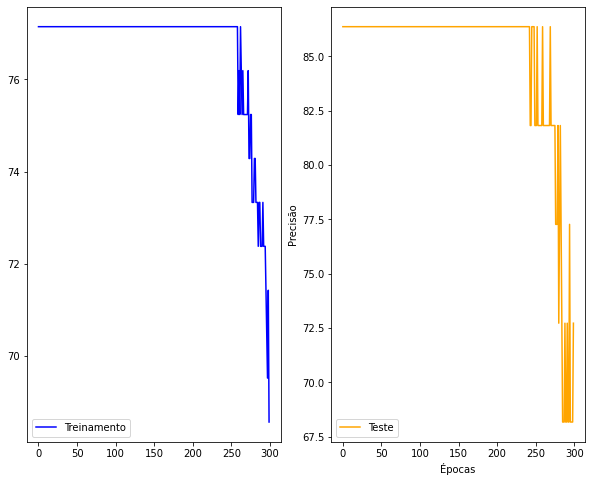

Melhor precisão de treinamento 77.14285714285698
Melhor precisão de teste 86.36363636363637
Melhor precisão de validação 73.91304347826087
Média precisão de treinamento 46.50793650793644
Média precisão de teste 48.03030303030303
Média precisão de validação 42.02898550724638
Desvio Padrão precisão de treinamento 18.98893075072105
Desvio Padrão precisão de teste 22.22732953247167
Desvio Padrão precisão de validação 19.324879189313958
Matriz de confusão de treinamento:
 [[38  0  0]
 [ 1 12 22]
 [ 0  1 31]]
Matriz de confusão de teste:
 [[7 0 0]
 [0 3 1]
 [0 2 9]]
Matriz de confusão de validação:
 [[9 0 0]
 [0 3 4]
 [0 2 5]]
Tempo de execução: 82.01398658752441 Segundos


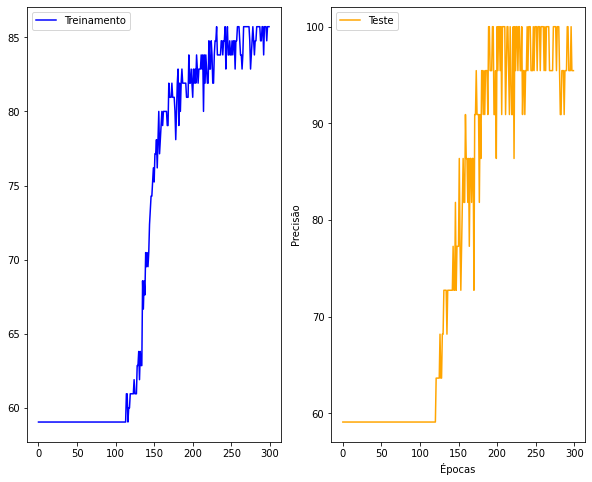

Melhor precisão de treinamento 85.71428571428552
Melhor precisão de teste 100.00000000000001
Melhor precisão de validação 78.26086956521739
Média precisão de treinamento 48.28571428571423
Média precisão de teste 50.15151515151515
Média precisão de validação 43.18840579710147
Desvio Padrão precisão de treinamento 20.390963273468778
Desvio Padrão precisão de teste 22.065621308039926
Desvio Padrão precisão de validação 21.85284269561828
Matriz de confusão de treinamento:
 [[28  2  0]
 [ 0 26 10]
 [ 0  3 36]]
Matriz de confusão de teste:
 [[9 0 0]
 [0 6 0]
 [0 0 7]]
Matriz de confusão de validação:
 [[10  1  0]
 [ 2  3  2]
 [ 0  0  5]]
Tempo de execução: 100.3085150718689 Segundos


In [56]:
executar_perceptron(funcao_ativacao_sigmoid, funcao_custo_mse, 300, [-0.005, 0.005])
executar_perceptron(funcao_ativacao_sigmoid, funcao_custo_rmse, 300, [-0.005, 0.005])

As duas funções de custo se saíram bem na busca dos resultados, posteriormente será testado qual consegue um desempenho médio melhor.

## Problema do gradiente explodindo ou desaparecendo
Um problema enfrentado foi o dos pesos explodindo ou sumindo. No primeiro caso, o valor dos pesos aumentava de forma exponencial, chegando a valores próximos dos 2000 mil por conexão sináptica. Isso gerou uma deteorização na precisão, fazendo com que os valores iniciais da rede sejam sempre os mais altos.

Já no gradiente sumindo, o problema foi uma taxa de aprendizado e um conjunto de pesos muito pequeno, fazendo com que a rede se mantenha uma linha reta, incapaz de aprender nada.

Para resolver esse problema foram feitos vários testes de diferentes pesos e taxas de aprendizado a fim de conseguir chegar a um meio termo, pois esses dois parâmetros são os principais responsáveis por fazer que isso ocorra.

# Atualização dos pesos por época
As redes neurais multicamadas geralmente atualizam os pesos da rede após passar todos os registros pela rede, ou pelo menos uma parte dos registros (batch). A atualização por época possui como vantagem um tempo de processamento menor, pois executa todo o processo na rede de uma vez só, sem precisar passar registro por registro, menos sensibilidade à dados ruidosos, pois generaliza os resultados de toda a rede e também um código de implementação mais simples (com menos linhas).
Todavia também possui algumas desvantagens, como maior uso de memória, pois precisa carregar todos os registros, o que pode ser impossível quando se trabalha com uma massa maior de dados além de que essa generalização dos resultados do *dataset* pode acabar levando à convergência a um ótimo local.

Pensando nisso, foi implementado uma versão que trabalha por épocas da rede perceptron para testar seu comportamento nos problemas aqui trabalhados. Foram necessárias algumas mudanças nos métodos já apresentados anteriormente.

Primeiro, os valores de classe e previsores foram reiniciados.

In [67]:
previsores = dataframe.iloc[:, 0:4] 
previsores = previsores.apply(lambda row: normalizacao_z_score(row))
previsores['bias'] = 1
classe = dataframe['class']
classe = classe.apply(lambda row: transformar_categorico_em_numerico(row, dict_classes))

Isso é necessário pois a classe foi codificada em um novo formato de matriz ao invés de array, para trabalhar com as operações matemáticas de uma vez só em todos os registros. Para isso, foram feitas alterações no método de *codificar_classe*. 

In [68]:
def codificar_classe_epoca():
    classe_codificada = {}
    
    array_classe = np.array([[1]  + ([0] * (len(classe.unique()) - 1)) ]) # estrutura de matriz
        
    count = 1
    classe_codificada[0] = array_classe.copy()

    for i in range(len(classe.unique()) - 1):
        array_classe[0][count - 1] = 0
        array_classe[0][count] = 1  
        classe_codificada[count] = array_classe.copy()
        count += 1
    
    return classe_codificada

Uma vez criado a estrutura de classe por matriz, criamos a variável *classe_nova* que vai transformar todas as classes do problema no formato de matriz.

In [69]:
classe_codificada = codificar_classe_epoca()
classe_nova = []

for i in classe: # percorre as classes do dataframe
    classe_nova.append(classe_codificada[i])
    
classe_nova = np.array(classe_nova).reshape(len(classe), 3) # redimensiona para criar a matriz
print(classe_nova.shape)

(150, 3)


A classe agora, ao invés de um array [0,1,0] é uma matriz com três colunas, uma para cada posição do array, como podemos ver no *print* do método *shape*, nos indicando as 150 linhas (registros) e três colunas (quantidade de classes).

Foi feito uma pequena modificação no método *dividir_dataframe*, porém não foi criado um novo método, apenas utilizamos um parâmetro adicional nesse caso.

A função sigmoid também recebe algumas modificações de sintax, pois ao invés de pegar o valor máximo de apenas um array e excitá-lo, o processo é feito de uma vez só no conjunto inteiro. 

In [70]:
def funcao_ativacao_sigmoid_epoca(soma):
    valor_ativacao = 1 / (1 + math.e ** -soma)
    index_excitacao = np.argmax(valor_ativacao, 1) 
    
    count = 0
    neuronios_excitado = valor_ativacao.copy()

    for i in index_excitacao:
        neuronios_excitado[count] = 0
        neuronios_excitado[count][i] = 1
        count += 1
        
    return neuronios_excitado, valor_ativacao

A função de custo utilizada foi a de Mean Squared Error, pois mostrou um bom desempenho nos testes. Foram feitas algumas pequenas adaptações para trabalhar com a operação matemática em todos os registros, mas a principal diferença é que na atualização por época, ao invés de contabilizar a precisão incrementalmente, ela é calculada de uma vez só, baseado no número de acertos em todos os registros.

In [71]:
def funcao_custo_mse_epoca(valor_correto, valor_previsto, valor_ativacao):
    erro = list(abs(np.array(valor_correto) - np.array(valor_previsto)))
    valor_erro = list(abs(np.array(valor_correto) - np.array(valor_ativacao)))

    acerto = 0
    for i in erro:
        if sum(i) == 0: # verifica se o registro está correto, ou seja, soma de erro é igual a 0.
            acerto += 1 # incrementa um no acerto

    erro_quadratico = list(map(lambda x: x**2, valor_erro))
    erro_quadratico_medio = sum(erro_quadratico) / len(valor_correto)

    return sum(erro), acerto, sum(erro_quadratico_medio)

A atualização dos pesos é a soma do valor atual do peso com o produto da multiplicação entre taxa de aprendizado, entrada e erro. Nesse caso, como trabalhamos com todas as entradas de uma vez só, é feito a média desse produto.

Essa média é a responsável por fazer a generalização de todas as entradas em um valor que será adicionado ao novo peso, sendo uma vantagem e ao mesmo tempo desvantagem dessa abordagem, como já foi discutido

In [59]:
def atualizar_peso_epoca(entrada, peso, erro, tx_aprendizado):
    novo_peso = peso + np.mean((tx_aprendizado * entrada * erro))
    return novo_peso

A matriz de confusão sofreu uma pequena modificação, pois os valores não precisam serem convertidos para um numpy array, uma vez que aqui está sendo trabalhado com a estrutura de matriz.

In [60]:
def get_matriz_confusao_epoca(valor_correto, valor_previsto):
    previsao = valor_previsto.copy()
    previsao = np.where(previsao == 1)[1]
    
    correto = valor_correto.copy()
    correto = np.where(correto == 1)[1]

    matriz_confusao = confusion_matrix(correto, previsao)

    return matriz_confusao

O método de testar fica mais simplificado, pois não precisa de loops em cada registro, além de já obter os acertos na própria função de ativação

In [66]:
def testar_epoca(pesos, x_previsores, y_classe, f_ativacao, f_custo):
    entradas = x_previsores.values  
    soma = somatoria(entradas, pesos)
    
    neuronio_excitado, valor_ativacao = f_ativacao(soma)
    matriz_confusao = get_matriz_confusao(y_classe, neuronio_excitado)

    erro, acertos, valor_erro = f_custo(y_classe, neuronio_excitado, valor_ativacao)
       
    return acertos / len(x_previsores), matriz_confusao

Assim como o teste, o treinamento acaba ficando mais simples, lidando com todos os dados de uma vez só

In [65]:
def treinar_epoca(epocas, f_ativacao, f_custo, pesos, x_treinamento, y_treinamento,
                                     x_teste, y_teste, tx_aprendizado):
    execucoes = 0
    precisoes_treinamento = []
    precisoes_teste = []
    melhores_pesos = []
    melhor_matriz_treinamento = []
    melhor_matriz_teste = []
    
    while execucoes < epocas:
        entradas = x_treinamento.values   
        soma = somatoria(entradas, pesos)
    
        neuronio_excitado, valor_ativacao = f_ativacao(soma)
    
        erro, acertos, valor_erro = f_custo(y_treinamento, neuronio_excitado, valor_ativacao)
    
        count = 0
        precisoes_treinamento.append(acertos / len(x_treinamento))  
        melhor_matriz_treinamento = get_matriz_confusao(y_treinamento, neuronio_excitado) if precisoes_treinamento[execucoes] >= max(precisoes_treinamento) else melhor_matriz_treinamento
        melhores_pesos = pesos.copy() if precisoes_treinamento[execucoes] >= max(precisoes_treinamento) else melhores_pesos

        for i in range(entradas.shape[1]): # o for tem que atualizar cada peso da camada
            if i == 4:
                novo_peso = atualizar_bias(entradas[:, i], pesos[i], valor_erro, tx_aprendizado)
            else:
                novo_peso = atualizar_peso_epoca(entradas[:, i], pesos[i], valor_erro, tx_aprendizado)
            pesos[count] = novo_peso
            count += 1

        teste_rede = testar_epoca(pesos, x_teste, y_teste, f_ativacao, f_custo)
        precisoes_teste.append(teste_rede[0])
        melhor_matriz_teste = teste_rede[1] if precisoes_teste[execucoes] >= max(precisoes_teste) else melhor_matriz_teste
        execucoes += 1
    
    return precisoes_treinamento, precisoes_teste, melhores_pesos, melhor_matriz_treinamento, melhor_matriz_teste

O novo método de executar perceptron vai ser muito parecido com o anterior, porém irá chamar todos os novos métodos que foram criados e executar a rede por épocas.

In [75]:
def executar_perceptron_epoca(funcao_ativacao, funcao_custo, epocas, dominio_pesos = [0, 1], 
                        tx_aprendizado = 0.1, mostrar_resultados = True):

    convergencia_treinamento = [0]
    convergencia_teste = [0]
    precisao_treinamento = []
    precisao_teste = []
    resultado_final = []
    matriz_confusao_treinamento = []
    matriz_confusao_teste = []
    matriz_confusao_validacao = []
    start_time = time.time()

    for i in range(30):
        pesos = inicializar_pesos(dominio_pesos) # Alterando os pesos em cada inicialização
        x_treinamento, y_treinamento, x_teste, y_teste, x_validacao, y_validacao = dividir_dataframe(previsores, classe_nova, 0.7, 0.15, 0.15, True)

        treinamento = treinar_epoca(epocas, funcao_ativacao, funcao_custo, pesos, x_treinamento, y_treinamento, x_teste, y_teste, tx_aprendizado)
                                     
        convergencia_treinamento = treinamento[0] if max(treinamento[0]) >= \
                                max(convergencia_treinamento) else convergencia_treinamento
        convergencia_teste = treinamento[1] if max(treinamento[1]) >= max(convergencia_teste) \
                                        else convergencia_teste
        
        precisao_treinamento.append(max(treinamento[0]))
        precisao_teste.append(max(treinamento[1]))
        
        teste_final = testar_epoca(treinamento[2], x_validacao, y_validacao, 
                                      funcao_ativacao, funcao_custo)
        
        resultado_final.append(teste_final[0])
        
        matriz_confusao_treinamento = treinamento[3] if max(treinamento[0]) >= max(precisao_treinamento) else matriz_confusao_treinamento
        matriz_confusao_teste = treinamento[4] if max(treinamento[1]) >= max(precisao_teste) else matriz_confusao_teste
        matriz_confusao_validacao = teste_final[1] if teste_final[0] >= max(resultado_final) else matriz_confusao_validacao

    if mostrar_resultados == True: # condição para caso não tenha interesse em plotar gráficos
        plotar_convergencia(convergencia_treinamento, convergencia_teste)   
        exibir_resultados(precisao_treinamento, precisao_teste, resultado_final)
        print("Tempo de execução: %s Segundos" % (time.time() - start_time))
        print('Matriz de confusão de treinamento:\n', matriz_confusao_treinamento)
        print('Matriz de confusão de teste:\n', matriz_confusao_teste)
        print('Matriz de confusão de validação:\n', matriz_confusao_validacao)
        
    return max(precisao_treinamento), max(precisao_teste), max(resultado_final)

In [ ]:
executar_perceptron_epoca(funcao_ativacao_sigmoid_epoca, funcao_custo_mse_epoca, 400, [-0.0005, 0.0005])

## Resultados do treinamento por época
Os resultados de precisão foram bons, chegando em torno dos 90% no teste da rede neural. 
Nesse caso, os resultados não foram tão diferentes do que executar o perceptron e atualizar os pesos por registro individual, mas aqui valem dois pontos de atenção. O primeiro é que a base de dados da iris não é de um problema muito complexo, além de ter uma quantidade pequena e separável de atributos, portanto atualizar olhando para atributos individualmente ou para todos os atributos de uma vez não fez tanta diferença. O segundo é que, como esperado, a execução do algoritmo por épocas conseguiu se sair até 6 vezes mais rápido do que o anterior, levando menos de 20 segundos para finalizar todas as execuções. Essa velocidade de processamento no possibilita testar uma combinação maior de hiperparâmetros, favorecendo a otimização da rede neural.

# Encontrando os melhores parâmetros
Existem algumas formas de encontrar os melhores resultados que um determinado algoritmo pode proporcionar. Uma delas é pelo teste exaustivo de parâmetros, onde são testados todas as combinações de parâmetros a fim de encontrar os melhores resultados.

Algoritmos como as redes neurais que possuem um quantidade maior de parâmetros se beneficiam desse tipo de abordagem, todavia o tempo de execução para esses testes muitas das vezes acaba sendo alto.

Para isso, foi criado o método *buscar_parametros*, que recebe um dicionário com uma lista de parâmetros, e cria uma lista com todos os parâmetros combinados.

Após isso, cada elemento da lista é executado, representando uma diferente possibilidade de combinação de parâmetros. Essa combinação é executada por 30 vezes no método *executar_perceptron*.

Ao final de todas as iterações, vamos ter os resultados finais obtidos bem como os melhores parâmetros para o algoritmo.

In [ ]:
def buscar_parametros(lista_parametros, executar):
    # cria uma única lista com todos os parâmetros
    parametros = [lista_parametros['custo'],
    lista_parametros['tx_aprendizado'], lista_parametros['pesos']]
    
    # Combinação de cada um desses parâmetros
    combinacao_parametros = list(itertools.product(*parametros))

    melhores_parametros = []
    melhor_precisao_teste = 0
    melhor_precisao_treinamento = 0
    melhor_precisao_validacao = 0
    # nesse for os parâmetros são testados
    for i in combinacao_parametros:
        precisao_treinamento, precisao_teste, resultado_final = executar(funcao_ativacao_sigmoid_epoca, i[0], 400, [-i[2], i[2]], i[1], False)
        # pegando os melhores resultados
        if resultado_final >= melhor_precisao_validacao:
            melhor_precisao_teste = precisao_teste
            melhor_precisao_treinamento = precisao_treinamento
            melhor_precisao_validacao = resultado_final
            melhores_parametros = i

    return melhores_parametros, melhor_precisao_teste, melhor_precisao_treinamento, melhor_precisao_validacao

In [ ]:
lista_parametros_epoca = { 'custo' : [funcao_custo, funcao_custo_mse],
                      'tx_aprendizado': [0.1, 0.01, 0.0001],
                      'pesos': [0.5, 0.05, 0.005, 0.0005]
}

teste_parametrico = buscar_parametros(lista_parametros_epoca, executar_perceptron_epoca)
print('Melhores parâmetros', teste_parametrico[0])
print('Melhor precisão teste', teste_parametrico[1])
print('Melhor precisão treinamento', teste_parametrico[2])
print('Melhor precisão validação', teste_parametrico[3])

É possível observar que o método de busca de parâmetros consegue automatizar o processo de encontrar os melhores parâmetros ao custo de um tempo de processamento maior. A busca foi feita apenas no algoritmo de atualização por época, por que na versão anterior de atualização de pesos por registros, levou mais de duas horas e ainda assim a busca não havia terminado, portanto foi interrompida. Na prática, a busca por melhores parâmetros pode levar dezenas de horas, porém é sempre interessante fazer testes manuais para reduzir a quantidade de combinações de parâmetros, para reduzir esse tempo. 

# Qual o problema?
Utilizar a base de dados de vinhos contidos aqui: http://archive.ics.uci.edu/ml/datasets/Wine para prever qual o tipo de vinho (1, 2 ou 3) baseado nas suas características.

O arquivo em questão não possuia colunas, assim como no conjunto da iris, portanto eu modifiquei o mesmo para adicionar o nome das colunas na primeira linha e deixá-lo no formato .CSV ao invés do .DATA.

## Anásile exploratória dos dados
Conhecendo um pouco mais dos dados da base de dados.

In [ ]:
dataframe = pd.read_csv('/home/alvaro/Documentos/mestrado/computação bio/redes neurais/datasets/wine.csv', header = 0)
dataframe.head()

In [ ]:
print('Valores nulos:')
print(dataframe.isna().sum())
dataframe.describe()

Nesse *dataset* todos os atributos são contínuos, inclusive a classe. Podemos notar que não existe nenhum valor vazio bem como aparentemente nenhum outlier/ruído.

## Normalização dos dados 
Assim como no problema da iris, esse dataset também precisa ser normalizando, ainda mais por conter uma quantidade maior de atributos previsores contínuos.

In [ ]:
previsores = dataframe.iloc[:, 1:14] 
classe = dataframe['Wine']

In [ ]:
previsores = previsores.apply(lambda row: normalizacao_z_score(row))
previsores.head()

A classe do tipo de vinho é distribuída em 1, 2 e 3, todavia para que meu método de codificar funcione ele precisa começar em 0, por isso, a classe de vinho foi submetida ao método de *transformar_categorico_em_numerico*, que vai transformá-la na sequência de 0, 1 e 2.

In [ ]:
dict_classes = get_dicionario_classes(classe)
classe = classe.apply(lambda row: transformar_categorico_em_numerico(row, dict_classes))
classe.value_counts()

Agora a classe vai ser codificada em uma array assim como aconteceu com a iris, pois temos novamente um problema do tipo multi-classe.

In [ ]:
classe_codificada = codificar_classe()
classe = classe.apply(lambda row: substituir_classe_codificada(row, classe_codificada))
classe.head()

Agora basta adicionar o neurônio na camada de entrada para ser o bias e executar o perceptron novamente para conferir os resultados da rede.

In [ ]:
previsores['bias'] = 1

In [ ]:
executar_perceptron(funcao_ativacao_sigmoid, funcao_custo_mse, 350, [-0.005, 0.005])

Agora o processo de leitura dos dados e pré-processamento deve ser repetido, porém agora de maneira um pouco diferente, para adequar os dados à rede perceptron por épocas, assim como foi feito anteriormente no problema das iris

In [ ]:
previsores = dataframe.iloc[:, 1:14] 
classe = dataframe['Wine']
previsores = previsores.apply(lambda row: normalizacao_z_score(row))

dict_classes = get_dicionario_classes(classe)
classe = classe.apply(lambda row: transformar_categorico_em_numerico(row, dict_classes))
classe_codificada = codificar_classe_epoca()

classe_nova = []

for i in classe:
    classe_nova.append(classe_codificada[i])
    
classe_nova = np.array(classe_nova).reshape(len(classe), 3)

previsores['bias'] = 1

In [ ]:
executar_perceptron_epoca(funcao_ativacao_sigmoid_epoca, funcao_custo_mse_epoca, 400, [-0.005, 0.005])

In [ ]:
lista_parametros_epoca = { 'custo' : [funcao_custo, funcao_custo_mse],
                      'tx_aprendizado': [0.1, 0.01, 0.0001],
                      'pesos': [0.5, 0.05, 0.005, 0.0005]
}

teste_parametrico = buscar_parametros(lista_parametros_epoca, executar_perceptron_epoca)
print('Melhores parâmetros', teste_parametrico[0])
print('Melhor precisão teste', teste_parametrico[1])
print('Melhor precisão treinamento', teste_parametrico[2])
print('Melhor precisão validação', teste_parametrico[3])

A rede perceptron, ainda que bastante simples, conseguiu resultados interessantes nesse problema considerado mais complexo, devido ao maior número de atributos previsores.

# Qual o problema?
O desafio escolhido no terceiro exercício foi construir uma rede neural multicamadas sem auxilio de bibliotecas prontas.


O conjundo de dados usado nesse desafio foi o de câncer de mama de Winsconsin, podendo ser encontrado aqui:
https://www.kaggle.com/uciml/breast-cancer-wisconsin-data

# Análise exploratória dos dados
Explorando o *dataset* e deixando em um formato correto para ser trabalhado.

In [1]:
dataframe = pd.read_csv('/home/alvaro/Documentos/mestrado/computação bio/redes neurais/datasets/breast cancer.csv', header = 0)
dataframe.head()

NameError: name 'pd' is not defined

O *dataframe* é composto basicamente de variáveis contínuas, com excessão apenas da classe, que representa um valor binário de M e B, indicando se o tumor extraído é malígno ou benígno.

Os atributos previsores são as características do tumor, como o formato, textura, área, entre outros.

Antes de mais nada é necessário dividir o conjunto em treinamento e teste, além de apagar algumas colunas que vieram junto no arquivo mas não serão utilizadas.

In [221]:
dataframe = dataframe.drop(columns = ['id', 'Unnamed: 32']) # ruído nos dados

previsores = dataframe.iloc[:, 1:32] # previsores
classe = dataframe['diagnosis'] # nome da coluna que representa a classe

In [2]:
print(dataframe.isna().sum())

NameError: name 'dataframe' is not defined

In [223]:
previsores.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000


Aparentemente essa base de dados também está em um formato já pronto para ser submetido à um algoritmo de aprendizado de máquina, não possuindo valores nulos ou outliers, porém é necessário antes normalizar os valores utilizando o z-score, da mesma forma que os conjuntos anteriores.

In [224]:
previsores = previsores.apply(lambda row: normalizacao_z_score(row))
previsores.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,0.639530,0.847771,0.149543,0.906679,-0.692439,0.203880,0.468187,1.425067
1,-0.844335,-1.122665,-0.160441,0.530556,-0.692439,-0.683976,-0.364823,-0.190548
2,1.233077,1.942458,-0.263769,-1.287373,-0.692439,-1.102537,0.604004,-0.105515
3,-0.844335,-0.997558,-0.160441,0.154433,0.123221,-0.493721,-0.920163,-1.040871
4,-1.141108,0.503727,-1.503707,0.906679,0.765337,1.408828,5.481337,-0.020483


In [225]:
classe.value_counts()

0    500
1    268
Name: Outcome, dtype: int64

Não será necessário transformar a classe em uma array ou uma matriz, pois se trata de um problema binário. Também é possível abservar que as classes estão relativamente bem balanceadas, uma vez que problemas envolvendo patologias geralmente são tratados como uma detecção de anomalia, pelo fato do paciente com a doença representar uma pequena fração de predominância no conjunto de dados, porém não foi o que aconteceu nesse caso.

# Implementação do multilayer perceptron
A ideia da rede neural perceptron multicamadas é parecido com a anterior, porém alguns conceitos matemáticos são adicionados, portanto os métodos tiveram que ser reconstruídos, com exceção apenas da função de soma que se mantém igual.

O método de *inicializar_pesos* por exemplo, acabou recebendo uma pequena modificação para conseguir distribuir dinamicamente os pesos baseado na quantidade de neurônios em cada camada e também na próxima camada adjacente.

In [226]:
def inicializar_pesos_mlp(neuronios_camada, dominio = [-1, 1]):
    pesos_final = []

    for i in range(len(neuronios_camada) - 1):
        pesos = []
        for j in range(neuronios_camada[i]):
            pesos.append([random.uniform(dominio[0], dominio[1]) for i in range(neuronios_camada[i + 1])])
        pesos_final.append(pesos)
    return pesos_final

A função de custo e a sigmoid estão bem simples, da mesma forma que a implementação original.

In [227]:
def funcao_ativacao_sigmoid(valor):
    resultado = 1 / (1 + np.exp(-valor))
    return resultado

In [228]:
def funcao_custo_mlp(valor_correto, valor_previsto):
    valor_erro = valor_correto - valor_previsto
    return valor_erro

## Feedfoward
O feedfoward é o nome dado ao processo de cálculo do resultado da função de ativação. O processo é simples igual no perceptron, todavia ele deve ser repetido para todas as camadas até chegar na camada de saída, diferentemente da versão anterior onde esse processo de somatória e aplicação da função de ativação era realizado apenas uma vez.

In [229]:
def feed_foward(pesos, x_treinamento, f_ativacao):
    ativacao = []
    for i in range(len(pesos)): # percorre todas as camadas
        if i == 0: # na camada de entrada os valores são os próprios atributos previsores
            soma_sinapse = np.dot(x_treinamento, pesos[i])
            ativacao.append(f_ativacao(soma_sinapse))
        else: # nas próximas camadas, o resultado anteriores dos neurônios são considerados.
            soma_sinapse = np.dot(ativacao[i - 1], pesos[i])
            ativacao.append(f_ativacao(soma_sinapse))

    return ativacao

## Calculando a derivada e o delta da camada de saída
A derivada e o delta da camada de saída são valores importantes para o ajuste dos pesos, usados no processo de retropropagação do erro. Portanto, foram criados funções que vão calcular os respectivos valores.

In [230]:
def calcular_derivada_parcial(valor):
    return valor * (1 - valor)

In [231]:
def calcular_delta(erro, derivada):
    return erro * derivada

O processo de cálculo de derivada e delta para as camadas ocultas é um pouco diferente, portanto foi criado uma função para servir a esse propósito específico

In [232]:
def calcular_delta_oculto(pesos, delta_saida, derivada):
    matriz_pesos = np.transpose(np.asmatrix(pesos)) # conceito de matriz transposta 

    pesos_delta_saida = delta_saida.dot(matriz_pesos)

    return derivada * np.array(pesos_delta_saida) # as matrizes precisam estar em uma dimensão diferente uma da outra

In [233]:
def get_delta_oculto(pesos, delta_saida, ativacao):
    deltas_camadas_ocultas = []  # pegar a derivada da saída

    for i in range(len(pesos) -1):
        if i == 0:
            derivada = calcular_derivada_parcial(ativacao[len(ativacao) - (i + 2)]) # pegar de trás para frente a derivada de cada neurônio
            deltas_camadas_ocultas.append(calcular_delta_oculto(pesos[len(pesos) - (i + 1)], delta_saida, derivada))
        else:
            derivada = calcular_derivada_parcial(ativacao[len(ativacao) - (i + 2)]) # pegar de trás para frente a derivada de cada neurônio
            deltas_camadas_ocultas.append(calcular_delta_oculto(pesos[len(pesos) - (i + 1)], deltas_camadas_ocultas[i - 1], derivada))

    return deltas_camadas_ocultas

## Backpropagation
Agora com todos os neurônios com os respectivos valores de delta e as derivadas, basta aplicar o algoritmo de retropropagação, começando da camada de saída até a camada de entrada.

O método recebe todos os valores que foram calculados até então, além da taxa de aprendizado e o momentum.

In [2]:
def backpropagation(pesos, ativacao, delta_saida, delta_oculto, x_treinamento, tx_aprendizado = 0.3, momento = 1):
    for i in range(len(pesos)):
        if i == len(pesos) - 1:
            valor_neuronio_transposto = np.transpose(x_treinamento.values)
            delta_x_entrada = valor_neuronio_transposto.dot(delta_oculto[0])
            pesos[len(pesos) - (1 + i)] = (pesos[len(pesos) - (1 + i)] * momento) + (tx_aprendizado * delta_x_entrada)
        elif i == 0:
            valor_neuronio_transposto = np.transpose(ativacao[len(ativacao) - (i + 1)])
            delta_x_entrada = valor_neuronio_transposto.dot(delta_saida)
            pesos[len(pesos) - (1 + i)] = (pesos[len(pesos) - (1 + i)] * momento) + (tx_aprendizado * delta_x_entrada) 
        else:
            valor_neuronio_transposto = np.transpose(ativacao[len(ativacao) - (i + 1)])
            delta_x_entrada = valor_neuronio_transposto.dot(delta_oculto[len(delta_oculto) - i])
            pesos[len(pesos) - (1 + i)] = (pesos[len(pesos) - (1 + i)] * momento) + (tx_aprendizado * delta_x_entrada)

    return pesos

Uma dificuldade encontrada foi ajustar as dimensões das matrizes para que as fórmulas sejam corretamente aplicadas, portanto por enquanto o perceptron só aceita uma única camada oculta.

## Precisão
O método *get_precisao* foi utilizado para calcular a diferença absoluta nas previsões da última camada do modelo com o valor real da classe, nos dando a precisão do algoritmo.

In [235]:
def get_precisao(valor_correto, valor_previsto):
    previsao = valor_previsto.copy()

    previsao[previsao >= 0.5] = 1
    previsao[previsao < 0.5] = 0

    precisao = (valor_correto == previsao).sum() / len(valor_correto)
    return precisao

## Matriz de confusão
A matriz de confusão é especialmente útil nesses casos, uma vez que estamos lidando com vidas de pacientes. Sabemos que em casos de patologias, é preferível um número maior de falsos positivos do que falsos negativos, pois é preferível diagnosticar o paciente com a doença e depois descartar através de mais exames do que descartar a possibilidade de doença e deixar que a condição de saúde seja agravada.

## Treinamento do algoritmo
O método *treinar_mlp* é o responsável por aplicar todas as contas que foram criadas anteriormente, atualizado os pesos em cada uma das épocas.

In [248]:
def treinar_mlp(epocas, neuronios_camada, f_ativacao, f_custo, pesos, x_treinamento,
                                     y_treinamento, x_teste, y_teste, tx_aprendizado):
    execucoes = 0
    precisoes_treinamento = []
    precisoes_teste = []
    melhores_pesos = []
    melhor_matriz = []

    while execucoes < epocas:               
        ativacao = feed_foward(pesos, x_treinamento, f_ativacao)

        resultado_camada_saida = ativacao[len(ativacao) - 1]
        classe_reshaped = y_treinamento.values.reshape(-1,1)

        erro = f_custo(classe_reshaped, resultado_camada_saida)

        precisoes_treinamento.append(get_precisao(classe_reshaped, resultado_camada_saida))

        derivada_saida = calcular_derivada_parcial(resultado_camada_saida)
        delta_saida = calcular_delta(erro, derivada_saida)

        delta_camada_oculta = get_delta_oculto(pesos, delta_saida, ativacao)

        melhores_pesos = pesos.copy() if precisoes_treinamento[execucoes] >= max(precisoes_treinamento) else melhores_pesos

        pesos = backpropagation(pesos, ativacao, delta_saida, delta_camada_oculta, x_treinamento) 
        
        precisoes_teste.append(testar_mlp(pesos, x_teste, y_teste, f_ativacao, f_custo))
        melhor_matriz = get_matriz_confusao(classe_reshaped, resultado_camada_saida) if precisoes_teste[execucoes] >= max(precisoes_teste) else melhor_matriz
        execucoes += 1
        
    return precisoes_treinamento, precisoes_teste, melhores_pesos, melhor_matriz

Para testar o desempenho ao final de cada época o método testar também passou por adaptações

In [237]:
def testar_mlp(pesos, x_previsores, y_classe, f_ativacao, f_custo):
    precisao = 0

    ativacao = feed_foward(pesos, x_previsores, f_ativacao)

    resultado_camada_saida = ativacao[len(ativacao) - 1]
    classe_reshaped = y_classe.values.reshape(-1,1)

    precisao = get_precisao(classe_reshaped, resultado_camada_saida)

    return precisao

## Adicionando camadas
A lógica foi construída para inicializar a estrutura de pesos baseado em uma Array que vai indicar o número de camadas e de neurônios em cada camada, portanto o processo de expandir a rede se torna simples.

In [238]:
neuronios_camada = [len(previsores.columns)] # adicionado neurônios da camada de entrada
neuronios_camada.append(10) # camada oculta
neuronios_camada.append(1) # camada de saída.

Foi criado por fim um método, chamado *executar_mlp*, com o mesmo objetivo dos métodos anteriores de executar, fazendo os tester na rede com 30 inicializações;

In [250]:
def executar_mlp(funcao_ativacao, funcao_custo, epocas, dominio_pesos = [-1, 1], 
                       tx_aprendizado = 0.001):

    convergencia_treinamento = [0]
    convergencia_teste = [0]
    precisao_treinamento = []
    precisao_teste = []
    resultado_final = []
    matriz_confusao = []
    start_time = time.time() # tempo de execução

    for i in range(30):
        x_treinamento, y_treinamento, x_teste, y_teste, \
        x_validacao, y_validacao = dividir_dataframe(previsores, classe, 0.7, 0.15, 0.15)

        pesos = inicializar_pesos_mlp(neuronios_camada, dominio_pesos)

        treinamento = treinar_mlp(epocas, neuronios_camada, funcao_ativacao, funcao_custo, pesos, x_treinamento, y_treinamento, x_teste, y_teste, tx_aprendizado)

        convergencia_treinamento = treinamento[0] if max(treinamento[0]) >= \
                                    max(convergencia_treinamento) else convergencia_treinamento

        convergencia_teste = treinamento[1] if max(treinamento[1]) >= max(convergencia_teste) \
                                        else convergencia_teste
        
        matriz_confusao.append(treinamento[3])
        precisao_treinamento.append(max(treinamento[0]))
        precisao_teste.append(max(treinamento[1]))
        resultado_final.append(testar_mlp(treinamento[2], x_validacao, y_validacao, 
                                      funcao_ativacao, funcao_custo))

    plotar_convergencia(convergencia_treinamento, convergencia_teste)   
    exibir_resultados(precisao_treinamento, precisao_teste, resultado_final)
    print(matriz_confusao[precisao_teste.index(max(precisao_teste))])
    print("Tempo de execução: %s Segundos" % (time.time() - start_time))

In [ ]:
executar_mlp(funcao_ativacao_sigmoid, funcao_custo_mlp, 300)

# Resultados da rede perceptron multicamadas
O algoritmo, ainda que sem muitos ajustes no parâmetros, conseguiu uma precisão de 100% em todas os conjuntos de dados, também sendo possível ver a consistência do mesmo, com uma média próxima aos 100% em todas as 30 execuções.
O que mais impressiona é o tempo de execução, sendo superiror até ao perceptron por épocas, claro que isso ocorre por se tratar de um problema simples, mas ainda é muito bom.

In [243]:
dict_classes = get_dicionario_classes(classe)
classe_codificada = codificar_classe()

classe_nova = []

for i in classe:
    classe_nova.append(classe_codificada[i])
    
classe_nova = np.array(classe_nova).reshape(len(classe), 2)

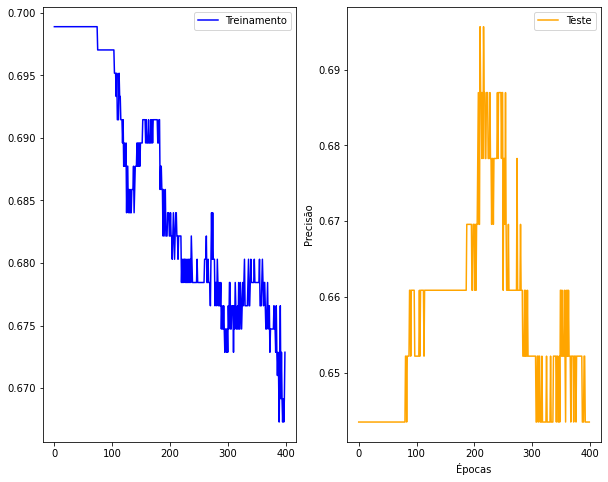

Melhor precisão de treinamento 0.6988847583643123
Melhor precisão de teste 0.6956521739130435
Melhor precisão de validação 0.7217391304347827
Média precisão de treinamento 0.5153655514250309
Média precisão de teste 0.5249275362318842
Média precisão de validação 0.5104347826086957
Desvio Padrão precisão de treinamento 0.09681491432770285
Desvio Padrão precisão de teste 0.09299289789559853
Desvio Padrão precisão de validação 0.11861732298939097
Tempo de execução: 45.40508317947388 Segundos


(0.6988847583643123, 0.6956521739130435, 0.7217391304347827)

In [245]:
executar_perceptron_epoca(funcao_ativacao_sigmoid_epoca, funcao_custo_mse_epoca, 400, [-0.005, 0.005])

In [ ]:
lista_parametros_epoca = { 'custo' : [funcao_custo_mse_epoca],
                      'tx_aprendizado': [0.1, 0.01, 0.0001],
                      'pesos': [0.5, 0.05, 0.005, 0.0005]
}

teste_parametrico = buscar_parametros(lista_parametros_epoca, executar_perceptron_epoca)
print('Melhores parâmetros', teste_parametrico[0])
print('Melhor precisão teste', teste_parametrico[1])
print('Melhor precisão treinamento', teste_parametrico[2])
print('Melhor precisão validação', teste_parametrico[3])

Mesmo após uma busca exaustiva de parâmetros, é possível observar a superioridade da rede perceptron multicamadas.

# Próximos passos
O algoritmo de perceptron multicamadas construído, apesar de eficiente, foi bem simples e algumas medidas poderiam ser feitas a fim de deixar ainda mais robusto:
* Aumentar o número de camadas e neurônios
* Descida do gradiente estocástica
* Dropout
* Parada no platô e redução dinâmica de taxa de aprendizado

# Conclusões
Os algoritmos de redes neurais extremamente competentes para resolver problemas mais complexos. O Perceptron consegue ser eficiênte quando lidamos com características linearmente separáveis e as redes perceptron multicamadas são as ideias em problemas mais complexos de serem separados espacialmete. Um problema enfrentado está no aumento do tempo de processamento e poder comp